# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Import Packages
import pickle
import numpy as np
import pandas as pd
import cv2 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Load pickled data

# Desktop
training_file = "/home/adarsh/software/udacity/train.p"
validation_file="/home/adarsh/software/udacity/valid.p"
testing_file = "/home/adarsh/software/udacity/test.p"

# Mac
# training_file = "/Users/akulkarni/Documents/udacity/traffic-signs-data/train.p"
# validation_file="/Users/akulkarni/Documents/udacity/traffic-signs-data/valid.p"
# testing_file = "/Users/akulkarni/Documents/udacity/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print("Loaded pkls")

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

Loaded pkls
(34799, 32, 32, 3) (34799,) (4410, 32, 32, 3) (4410,) (12630, 32, 32, 3) (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Text(0.5,1,'Histogram of Labels in Test Set')

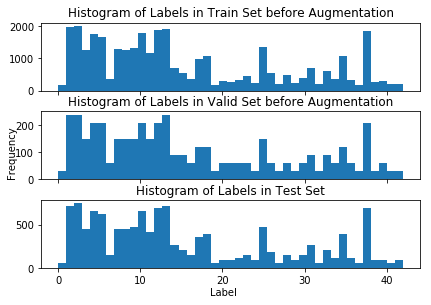

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(3, 1, sharex=True)
fig.tight_layout()
axes[0].hist(y_train, bins=n_classes)
fig.text(0.5, 0, 'Label', ha='center')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')
axes[0].set_title("Histogram of Labels in Train Set before Augmentation")
axes[1].hist(y_valid, bins=n_classes)
axes[1].set_title("Histogram of Labels in Valid Set before Augmentation")
axes[2].hist(y_test, bins=n_classes)
axes[2].set_title("Histogram of Labels in Test Set")

# For when exporting pictures for the writeup
# plt.savefig('histogram_labels.png', bbox_inches='tight')

### Under-represented Labels
The next few code segments are designed to increase the quantity for under represented labels. For example, no label should have less than 1000 items in the train set. For the purposes of this operation, I merged train and validation and then created a new split. The test set was not touched.

(39209, 32, 32, 3) (39209,)


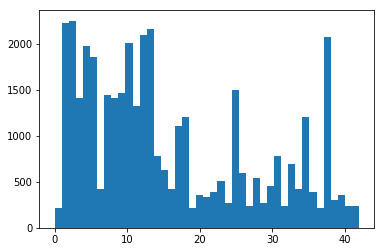

In [4]:
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))
plt.hist(y, bins=n_classes)
print(X.shape, y.shape)

uniques, counts = np.unique(y, return_counts=True)

more_X = []
more_y = []

for i in range(len(X)):
    if(counts[y[i]] < 1000):
        num_added = 1000 - counts[y[i]]
        for j in range(num_added):
            more_X.append(X[i])
            more_y.append(y[i])
            counts[y[i]] += 2

X_new = np.concatenate((X, more_X))
y_new = np.concatenate((y, more_y))

(54710, 32, 32, 3) (54710,)


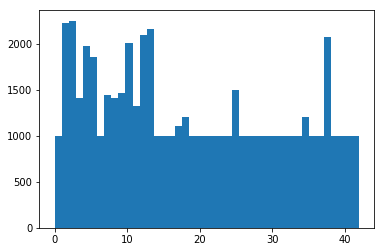

In [5]:
plt.hist(y_new, bins=n_classes)
print(X_new.shape, y_new.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
def grayscale_images(img_arr):
    '''
    Take an array of images and return a new
    array of the same images all grayscaled
    '''
    grey_imgs = []
    for img in img_arr:
        grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        grey_imgs.append(grey_img)
    
    return np.array(grey_imgs)


def normalize_images(img_arr):
    '''
    Take in an array of images and return a 
    normalized array of the same images
    in practice this only runs with grayscale images, 
    but it should work on 3 channel as well
    '''
    normalized_imgs = []
    for img in img_arr:
        img = np.array(img).astype(np.int16)
        normalized_img = (img - 128) / 128
        normalized_img = normalized_img[:, :, np.newaxis]
        normalized_imgs.append(normalized_img)
    return np.array(normalized_imgs)


# Attempted this, but didn't have time to fully see it through
def convert_YUV(img_arr):
    yuv_imgs = []
    for img in img_arr:
        yuv_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        yuv_imgs.append(grey_img)
    
    return np.array(yuv_imgs)


X_gray_new = grayscale_images(X_new)
X_new_preprocessed = normalize_images(X_gray_new)

# Generating a sample grayscale image for the writeup
# cv2.imwrite("sample_gray.png", X_gray_new[0])

X_test_grey = grayscale_images(X_test)
X_test_preprocessed = normalize_images(X_test_grey)

X_train, X_valid, y_train, y_valid = train_test_split(X_new_preprocessed, y_new, test_size = 0.1, shuffle=True)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(49239, 32, 32, 1) (5471, 32, 32, 1) (49239,) (5471,)


### Model Architecture

In [7]:
import tensorflow as tf

def Network(x):    
    # Input 32x32x1
    
    conv1 = tf.layers.conv2d(x, filters=16, kernel_size=(5,5), padding='SAME', activation=tf.nn.relu, name='conv1')
    # Now 32x32x16
    
    conv1_norm = tf.layers.batch_normalization(conv1, training=True, trainable=True, renorm=True, name='conv1_norm')
    
    maxpool1 = tf.layers.max_pooling2d(conv1_norm, pool_size=(2,2), strides=(2,2), padding='SAME', name='maxpool1')
    # Now 16x16x16
    
    conv2 = tf.layers.conv2d(inputs=maxpool1, filters=32, kernel_size=(3,3), padding='SAME', activation=tf.nn.relu, name='conv2')
    # Now 16x16x32
    
    conv2_norm = tf.layers.batch_normalization(conv2, training=True, trainable=True, renorm=True, name='conv2_norm')
    
    maxpool2 = tf.layers.max_pooling2d(conv2_norm, pool_size=(2,2), strides=(2,2), padding='SAME', name='maxpool2')
    # Now 8x8x32
    
    fully_connected_0 = tf.layers.flatten(maxpool2)
    # Now 2,048 
    
    dropout1 = tf.layers.dropout(inputs=fully_connected_0, rate=0.5,)
    
    fully_connected_1 = tf.layers.dense(dropout1, 512, activation=tf.nn.relu, name='fully_connected_1')
    # Now 512
    
    dropout2 = tf.layers.dropout(inputs=fully_connected_1, rate=0.5,)
    
    fully_connected_2 = tf.layers.dense(dropout2, 128, activation=tf.nn.relu, name='fully_connected_2')
    # Now 128
    
    dropout3 = tf.layers.dropout(inputs=fully_connected_2, rate=0.5)
    
    logits = tf.layers.dense(dropout3, n_classes, activation=tf.nn.relu, name='logits')
    # Now n_classes
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
# Create Placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Learning Rate
rate = 0.0001

# Training Operations and Optimizers
logits = Network(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy Calculations
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Saver Object
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    '''
    Compute the accuracy of the current model on a given X and y
    '''
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


In [9]:
BATCH_SIZE = 1024
EPOCHS = 500

# Ensure that the computer keeps working while training!
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.85)

# Create the TF Session and train!
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...\n")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        train_accuracy = evaluate(X_train, y_train)
        
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}\n".format(validation_accuracy))
        
        # Every 10 epochs, save the model and compute Test Acuracy
        if i % 10 == 0:    
            test_accuracy = evaluate(X_test_preprocessed, y_test)
            saver.save(sess, ('./trained_model_6_%s.ckpt' % i))
            
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            print("Model saved\n")

Training...

EPOCH 1 ...
Train Accuracy = 0.469
Validation Accuracy = 0.477

Test Accuracy = 0.305
Model saved

EPOCH 2 ...
Train Accuracy = 0.665
Validation Accuracy = 0.661

EPOCH 3 ...
Train Accuracy = 0.781
Validation Accuracy = 0.769

EPOCH 4 ...
Train Accuracy = 0.849
Validation Accuracy = 0.837

EPOCH 5 ...
Train Accuracy = 0.922
Validation Accuracy = 0.906

EPOCH 6 ...
Train Accuracy = 0.947
Validation Accuracy = 0.928

EPOCH 7 ...
Train Accuracy = 0.958
Validation Accuracy = 0.939

EPOCH 8 ...
Train Accuracy = 0.965
Validation Accuracy = 0.946

EPOCH 9 ...
Train Accuracy = 0.968
Validation Accuracy = 0.952

EPOCH 10 ...
Train Accuracy = 0.972
Validation Accuracy = 0.956

EPOCH 11 ...
Train Accuracy = 0.975
Validation Accuracy = 0.961

Test Accuracy = 0.849
Model saved

EPOCH 12 ...
Train Accuracy = 0.976
Validation Accuracy = 0.962

EPOCH 13 ...
Train Accuracy = 0.977
Validation Accuracy = 0.965

EPOCH 14 ...
Train Accuracy = 0.978
Validation Accuracy = 0.966

EPOCH 15 ...
Tra

EPOCH 121 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

Test Accuracy = 0.893
Model saved

EPOCH 122 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 123 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 124 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 125 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 126 ...
Train Accuracy = 0.981
Validation Accuracy = 0.974

EPOCH 127 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 128 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 129 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 130 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 131 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

Test Accuracy = 0.894
Model saved

EPOCH 132 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 133 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 134 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 

EPOCH 239 ...
Train Accuracy = 0.981
Validation Accuracy = 0.974

EPOCH 240 ...
Train Accuracy = 0.981
Validation Accuracy = 0.974

EPOCH 241 ...
Train Accuracy = 0.981
Validation Accuracy = 0.974

Test Accuracy = 0.899
Model saved

EPOCH 242 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 243 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 244 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 245 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 246 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 247 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 248 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 249 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 250 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 251 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

Test Accuracy = 0.899
Model saved

EPOCH 252 ...
Train Accuracy = 0.981
Validation Accuracy = 0.974

EPOCH 

EPOCH 357 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 358 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 359 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 360 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 361 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

Test Accuracy = 0.899
Model saved

EPOCH 362 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 363 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 364 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 365 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 366 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 367 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 368 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 369 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 370 ...
Train Accuracy = 0.981
Validation Accuracy = 0.975

EPOCH 371 ...
Train Accuracy = 0.981
Vali

EPOCH 475 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

EPOCH 476 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

EPOCH 477 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

EPOCH 478 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

EPOCH 479 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

EPOCH 480 ...
Train Accuracy = 0.981
Validation Accuracy = 0.977

EPOCH 481 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

Test Accuracy = 0.904
Model saved

EPOCH 482 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

EPOCH 483 ...
Train Accuracy = 0.981
Validation Accuracy = 0.977

EPOCH 484 ...
Train Accuracy = 0.981
Validation Accuracy = 0.977

EPOCH 485 ...
Train Accuracy = 0.981
Validation Accuracy = 0.977

EPOCH 486 ...
Train Accuracy = 0.981
Validation Accuracy = 0.977

EPOCH 487 ...
Train Accuracy = 0.981
Validation Accuracy = 0.977

EPOCH 488 ...
Train Accuracy = 0.981
Validation Accuracy = 0.976

EPOCH 489 ...
Train Accuracy = 0.981
Vali

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

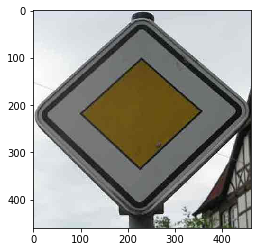

In [10]:
# Read in Priority Road Image and show it
priority_road = cv2.imread("./images/priority_road.jpg")
cv2.imwrite("priority_road_resized_.jpg", cv2.resize(priority_road, (32,32)))
plt.imshow(cv2.cvtColor(priority_road, cv2.COLOR_BGR2RGB))

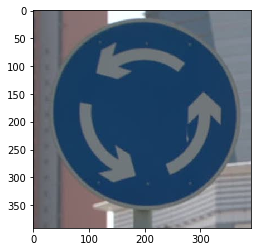

In [11]:
# Read in Mandatory Roundabout Image and show it
mandatory_roundabout = cv2.imread("./images/mandatory_roundabout.jpg")
cv2.imwrite("mandatory_roundabout_resized_.jpg", cv2.resize(mandatory_roundabout, (32,32)))
plt.imshow(cv2.cvtColor(mandatory_roundabout, cv2.COLOR_BGR2RGB))

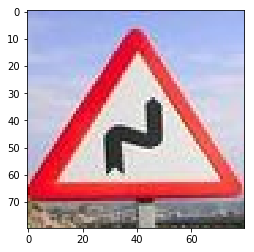

In [12]:
# Read in Double Curve Image and show it
double_curve = cv2.imread("./images/double_curve.jpg")
cv2.imwrite("double_curve_resized_.jpg", cv2.resize(double_curve, (32,32)))
plt.imshow(cv2.cvtColor(double_curve, cv2.COLOR_BGR2RGB))

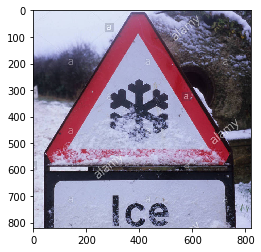

In [13]:
# Read in Beware of Ice/Snow Image and show it
beware_ice_snow = cv2.imread("./images/beware_ice_snow.jpg")
cv2.imwrite("beware_ice_snow_resized_.jpg", cv2.resize(beware_ice_snow, (32,32)))
plt.imshow(cv2.cvtColor(beware_ice_snow, cv2.COLOR_BGR2RGB))

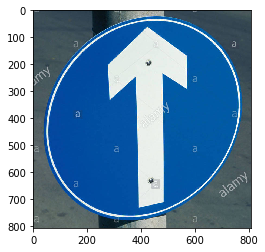

In [14]:
# Read in Ahead Only Image and show it
ahead_only = cv2.imread("./images/ahead_only.jpg")
cv2.imwrite("ahead_only_resized_.jpg", cv2.resize(ahead_only, (32,32)))
plt.imshow(cv2.cvtColor(ahead_only, cv2.COLOR_BGR2RGB))

### Predict the Sign Type for Each Image

In [15]:
def preprocess_extra_images(img):
    '''
    Method for Preprocessing all the new images
    '''
    img = cv2.resize(img, (32,32))
    img = img[np.newaxis, :, :, :]
    img = grayscale_images(img)
    img = normalize_images(img)
    return img[0]

# Preprocess all the new images
priority_road = preprocess_extra_images(priority_road)
ahead_only = preprocess_extra_images(ahead_only)
beware_ice_snow = preprocess_extra_images(beware_ice_snow)
double_curve = preprocess_extra_images(double_curve)
mandatory_roundabout = preprocess_extra_images(mandatory_roundabout)

# Create an inference feed dictionary for the new images
feed_dict_x = [priority_road, ahead_only, beware_ice_snow, double_curve, mandatory_roundabout]

In [16]:
# Create an easy to use array of the sign names
import csv

filename = "./signnames.csv"
id_to_name = []

with open(filename, 'r') as f:
    reader = csv.DictReader(f)
    for i, line in enumerate(reader):
        id_to_name.append(line["SignName"])
print (id_to_name)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

### Analyze Performance

In [19]:
# Start with a Clean Slate
tf.reset_default_graph()

# Once again, placeholders and Inference
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
correct = tf.constant([12, 35, 30, 21, 40], dtype=tf.int64)
one_hot_y = tf.one_hot(y, n_classes)
logits = Network(x)

# Saver to restore from the best checkpoint
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./trained_model_6_490.ckpt")
    l_gits = sess.run(logits, feed_dict={x: feed_dict_x, y:[12, 35, 30, 21, 40]})
    softmax = tf.nn.softmax(logits=l_gits)
    argmax = tf.argmax(softmax,1)
    equal = tf.equal(argmax, correct)
    accuracy_operation = tf.reduce_mean(tf.cast(equal, tf.float32))
    
    print ("Accuracy of the model on new images is %d%%" % int((accuracy_operation.eval() * 100)))
    
    for item in softmax.eval():
        values, indices = tf.nn.top_k(item, k=5)
        id_labels = [id_to_name[item] for item in indices.eval()]
        
        for idx, (value, label) in enumerate(zip(values.eval(), id_labels)):
            print ("Top %d Label is %s with %f%% Confidence" % ((idx+1), label, (value * 100)))
        print("\n")

INFO:tensorflow:Restoring parameters from ./trained_model_6_490.ckpt
Accuracy of the model on new images is 60%
Top 1 Label is Priority road with 99.913412% Confidence
Top 2 Label is Roundabout mandatory with 0.067410% Confidence
Top 3 Label is End of all speed and passing limits with 0.011121% Confidence
Top 4 Label is Keep right with 0.007147% Confidence
Top 5 Label is End of no passing by vehicles over 3.5 metric tons with 0.000455% Confidence


Top 1 Label is Ahead only with 99.996758% Confidence
Top 2 Label is Keep right with 0.001538% Confidence
Top 3 Label is Yield with 0.000757% Confidence
Top 4 Label is Turn left ahead with 0.000578% Confidence
Top 5 Label is Go straight or left with 0.000021% Confidence


Top 1 Label is Road work with 99.741793% Confidence
Top 2 Label is Bumpy road with 0.172494% Confidence
Top 3 Label is Priority road with 0.035479% Confidence
Top 4 Label is Go straight or left with 0.033685% Confidence
Top 5 Label is Roundabout mandatory with 0.010487% Conf

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [18]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")